# MCMC Inference in Hierarchical Bayesian Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
# import mkl

from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

np.random.seed(1234)
# mkl.set_num_threads(2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [14, 7]

## Usefull imports

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

## Useful utility functions

In [3]:
def lr_plot_posterior_samples(ax, w_samples, data_x, data_y, data_ys, fill=False, title=None):
    '''
    Plot samples from a Bayesian linear regression.
    
    Args:
        ax:        Axis for plotting.
        w_samples: Samples from the posterior over regression parameters
        data_x:    Explanatory variables.
        data_y:    Responses.
        data_ys:   Uncertainty in data_y.
        fill:      Whether to fill area between the first and the last sample.
        title:     Plot title.
    '''
    ax.errorbar(data_x[:, 0], data_y[:, 0], data_ys, None, marker="o", ls='', capsize=5)
    ax.set_xlabel('x', fontsize='xx-large')
    ax.set_ylabel('y', fontsize='xx-large')

    xmin, xmax = np.min(data_x[:, 0]), np.max(data_x[:, 0])
    X = np.array([[xmin, 1], [xmax, 1]])
    
    Y = X @ tf.transpose(w_samples)
    Y = tf.transpose(Y)
    for y in Y:
        ax.plot(X[:, 0], y, marker='', lw=1.0, alpha=0.5, color='r');
    
    if fill:
        plt.fill_between(X[:, 0], Y[0, :], Y[-1, :], alpha=0.3)
    
    if title is not None:
        ax.set_title(title, fontsize='x-large')

In [4]:
def plot_posterior_dist(samples, labels, cri=95, round_ticks=False):
    '''
    Plot posterior distributions for parameters of a Bayesian model.
    
    Args:
        samples:     a list of tensors with posterior samples (one tensor per parameter)
        labels:      a list of parameter names (strings)
        cri:         credible interval
        round_ticks: whether to use integer ticks in distribution plots
    '''
    n_params = len(samples)
    cri = (100 - cri) / 2
    
    f, axes = plt.subplots(1, n_params, figsize=(14, 7))
    if n_params == 1:
        axes = [axes]
    
    for i, ax in enumerate(axes):
        g = sns.histplot(samples[i], kde=True, ax=ax)
        ax.set_xlabel(labels[i], fontsize='xx-large')
        ax.set_ylabel('Count', fontsize='xx-large')
        
        low  = np.percentile(samples[i], cri)
        high = np.percentile(samples[i], 100-cri)
        ax.axvline(x=low, linestyle='--')
        ax.axvline(x=high, linestyle='--')
        if round_ticks:
            ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

## Bayesian Linear Regression (again)

We will start our introduction to MCMC with a known simple model - Bayesian Linear Regression with unknown $\sigma$.

In [5]:
# D.W. Hogg et al. Data analysis recipes: Fitting a model to data, https://arxiv.org/abs/1008.4686, 2010
hogg_data = np.array([[201, 592, 61],
                      [244, 401, 25],
                      [47, 583, 38],
                      [287, 402, 15],
                      [203, 495, 21],
                      [58, 173, 15],
                      [210, 479, 27],
                      [202, 504, 14],
                      [198, 510, 30],
                      [158, 416, 16],
                      [165, 393, 14],
                      [201, 442, 25],
                      [157, 317, 52],
                      [131, 311, 16],
                      [166, 400, 34],
                      [160, 337, 31],
                      [186, 423, 42],
                      [125, 334, 26],
                      [218, 533, 16],
                      [146, 344, 22]], dtype=np.float32)


hogg_x_npy, hogg_y_npy, hogg_ys_npy = hogg_data[:, 0], hogg_data[:, 1], hogg_data[:, 2]
hogg_x_npy, hogg_y_npy = hogg_x_npy[:, None], hogg_y_npy[:, None]

ones = np.ones((hogg_x_npy.shape[0], 1))
hogg_x_npy = np.concatenate((hogg_x_npy, ones), axis=1)

hogg_x = tf.constant(hogg_x_npy, dtype=tf.float32)
hogg_y = tf.constant(hogg_y_npy, dtype=tf.float32)
hogg_ys = tf.constant(hogg_ys_npy, dtype=tf.float32)

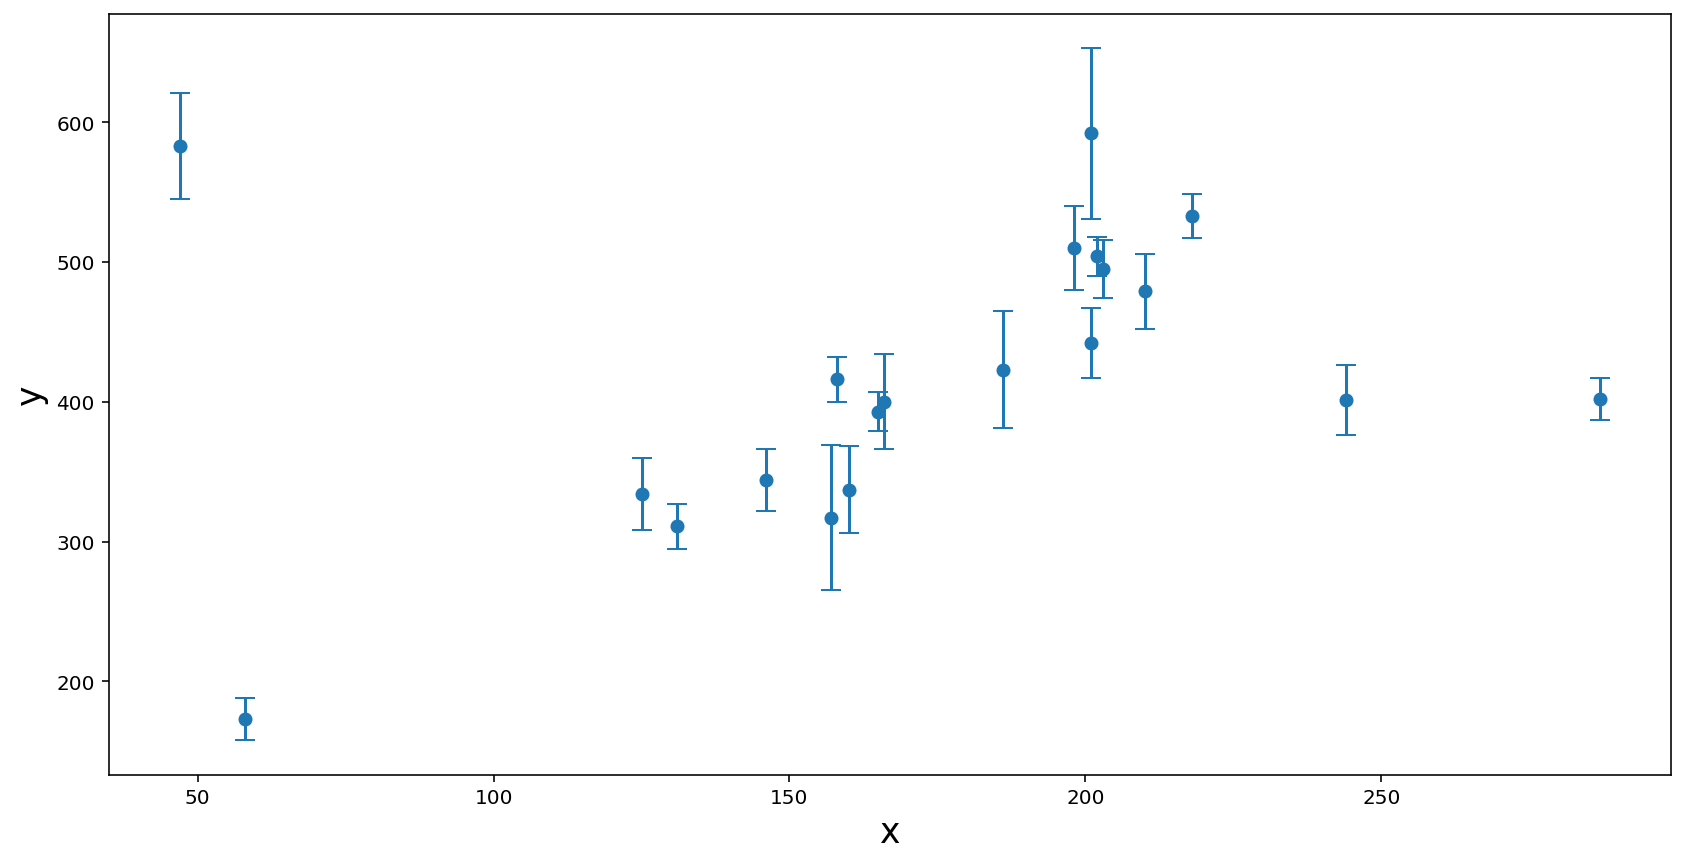

In [6]:
fig = plt.figure(figsize=(14, 7))
plt.errorbar(hogg_x[:, 0], hogg_y[:, 0], hogg_ys, None, marker="o", ls='', capsize=5)
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('y', fontsize='xx-large');

Lets recall our model from the previous lab:

$$\large
\begin{aligned}
  \sigma & \sim \mathrm{HalfCauchy}\left(\mathrm{loc} = 0,\ \mathrm{scale} = 10\right) \\
  \mathbf{w} & \sim N \left(\boldsymbol \mu_0, \mathbf{\Sigma}_0 \right) \\
  y \mid \mathbf{x}, \mathbf{w}, \mathbf{\sigma} & \sim
    N \left(\mathbf{w}^\mathsf{T}\mathbf{x}, \sigma^2 \right)
\end{aligned}
$$

We will now infer parameters of this model with Markov Chain Monte Carlo.

---

As usuall, we will begin by defining prior distributions.

In [7]:
y_mean, y_var = np.mean(hogg_y[:, 0]), np.var(hogg_y[:, 0])

mu_0_npy    = np.array([0, y_mean])
Sigma_0_npy = np.array([[1, 0],
                        [0, y_var]])

mu_0, Sigma_0 = tf.constant(mu_0_npy, dtype=tf.float32), tf.constant(Sigma_0_npy, dtype=tf.float32)

In [8]:
prior_w     = tfd.MultivariateNormalFullCovariance(tf.squeeze(mu_0), Sigma_0)
prior_sigma = tfd.HalfCauchy(loc=0, scale=10)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


The posterior in our model has the following form:

$$\large
p\left(\mathbf{w}, \sigma \mid D\right) =  \frac{1}{Z} p\left(D \mid \mathbf{w}, \sigma\right)
                                                       p\left(\mathbf{w}\right)
                                                       p\left(\sigma\right)
$$

There’s is no way we could calculate the normalization constant $Z$. But we know from the lecture that MCMC will work as well with unnormalized posterior. Note that this unnormalized posterior can be seen as the joint probability density of observations and parameters:

$$\large
p\left(D, \mathbf{w}, \sigma\right) =  p\left(D \mid \mathbf{w}, \sigma\right)
                                       p\left(\mathbf{w}\right)
                                       p\left(\sigma\right)
$$

Actual MCMC implementations doesn't work with this joint density directly. They instead expect a logarithm of the joint density - a so called log-joint:

$$\large
\log p\left(D, \mathbf{w}, \sigma\right) =  \log p\left(D \mid \mathbf{w}, \sigma\right) +
                                            \log p\left(\mathbf{w}\right) +
                                            \log p\left(\sigma\right)
$$

---

Let's implement the log-joint density for the Bayesian Linear Regression model. For reasons that will be clear shortly we will split regression slope and intercept into two separate arguments.

Complete the implementation of `lr_log_joint` function following comments in the code.

In [9]:
def lr_log_joint(w0, w1, sigma):
    '''
    Calculate log-joint density in Bayesian Linear Regression model.
    
    Args:
        w0: linear regression slope
        w1: linear regression intercept
        sigma: standard deviation of measurement errors
               (uncertainty of observations)
               
    Returns:
        Logarithm of the joint density of observations (hogg_x, hogg_y) and
        parameters (w, sigma).
    '''
    
    # Following our convention, we keep regression parameters in a single vector. 
    # So we begin by stacking w0 and w1 tensors.
    w = tf.stack([w0, w1])
    
    # Now we can calculate expected value in the linear regression fit.
    Z = hogg_x @ tf.reshape(w, [-1, 1])
    
    # We now have all that's needed to calculate the log-likelihood.
    density = tfd.Normal(Z, sigma)
    logd = density.log_prob(hogg_y)
    ll = tf.reduce_sum(logd)
    
    # And finally we can calculate log-joint
    logp = ll + prior_w.log_prob(w) + prior_sigma.log_prob(sigma)
    
    return logp

### MCMC machinery

We are now ready to setup our MCMC infrastructure. We will use Hamiltonian Monte Carlo (HMC), but you can also easily switch to NUTS.

---

First we define the transition kernel. All MCMC kernels take a handle to the log-probability function as their argument. HMC also requires a step-size and number of steps to take in each proposal.

Now, note something important - we provide a list of three different step sizes! This is no mistake - these step sizes correspond to the parameters listed as arguments in the log-joint function. So:
- Regression slope has a step size of 0.1 - seems reasonable as we expect regression slope to be a small number around 0.
- Regression intercept has a step size of 10.0 - note that intercept seems to vary on the scale of hundreds,
- Measurement error ($\sigma$) has a step size of 1.0 - we expect it to be somewhere between a few dozens to perhaps a hundred.

It should be clear now why we split $\mathbf{w}$ into two arguments in `lr_log_joint` - we want separate step size of regression slope and intercept.

In [10]:
lr_hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=lr_log_joint,
    step_size=[0.1, 10.0, 1.0],
    num_leapfrog_steps=2)

#lr_nuts_kernel = tfp.mcmc.NoUTurnSampler(
#    target_log_prob_fn=lr_log_joint,
#    step_size=[0.1, 10.0, 1.0])

We will now define a function that will run our Markov Chain. This function simply wraps `tfp.mcmc.sample_chain` from TensorFlow probability.

There is a good reason why we wrap `tfp.mcmc.sample_chain` - it's the `@tf.function` decorator. It tells TensorFlow to treat the whole `run_chain` function as a computation graph, rather than simple eagerly evaluated function. So when we execute `run_chain` TensorFlow will construct a computation graph for the whole MCMC procedure, optimize that graph and then execute it. Graph optimization will save us a lot of computing time. 

In [11]:
@tf.function(experimental_relax_shapes=True)
def run_chain(kernel, initial_state, num_results=1000, num_burnin_steps=1000):
    '''
    Sample Markov chain.
    
    Args:
        kernel:           transition kernel
        initial_state:    initial state of the chain
        num_results:      number of samples to return
        num_burnin_steps: number of initial steps to throw away (burn-in period)
        
    Returns:
        Samples from the chain and trace of kernel executions.
    '''
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=kernel,
        trace_fn=lambda current_state, kernel_results: kernel_results)

Next in line is the initial state of the chain. We will use $\boldsymbol \mu_0$ for initial $\mathbf{w}$ and a reasonable guess for $\sigma$.

In [12]:
lr_initial_state = [mu_0[0], mu_0[1], 25.0]

And finally we can run the chain :)

In [13]:
lr_samples, lr_kernel_results = run_chain(lr_hmc_kernel,
                                          lr_initial_state,
                                          num_results=1000,
                                          num_burnin_steps=1000)

print("Acceptance rate: ", lr_kernel_results.is_accepted.numpy().mean())

Acceptance rate:  0.933


Let's see if our samples agree with Importance Sampling results (see previous lab).

In [14]:
sigma_samples = lr_samples[2].numpy()

w_samples = tf.stack([lr_samples[0], lr_samples[1]], axis=1).numpy()

In [15]:
sigma_mean, sigma_std = np.mean(sigma_samples), np.std(sigma_samples)
print(f'sigma: {sigma_mean:.4} +- {sigma_std:.3}')

sigma: 94.24 +- 14.2


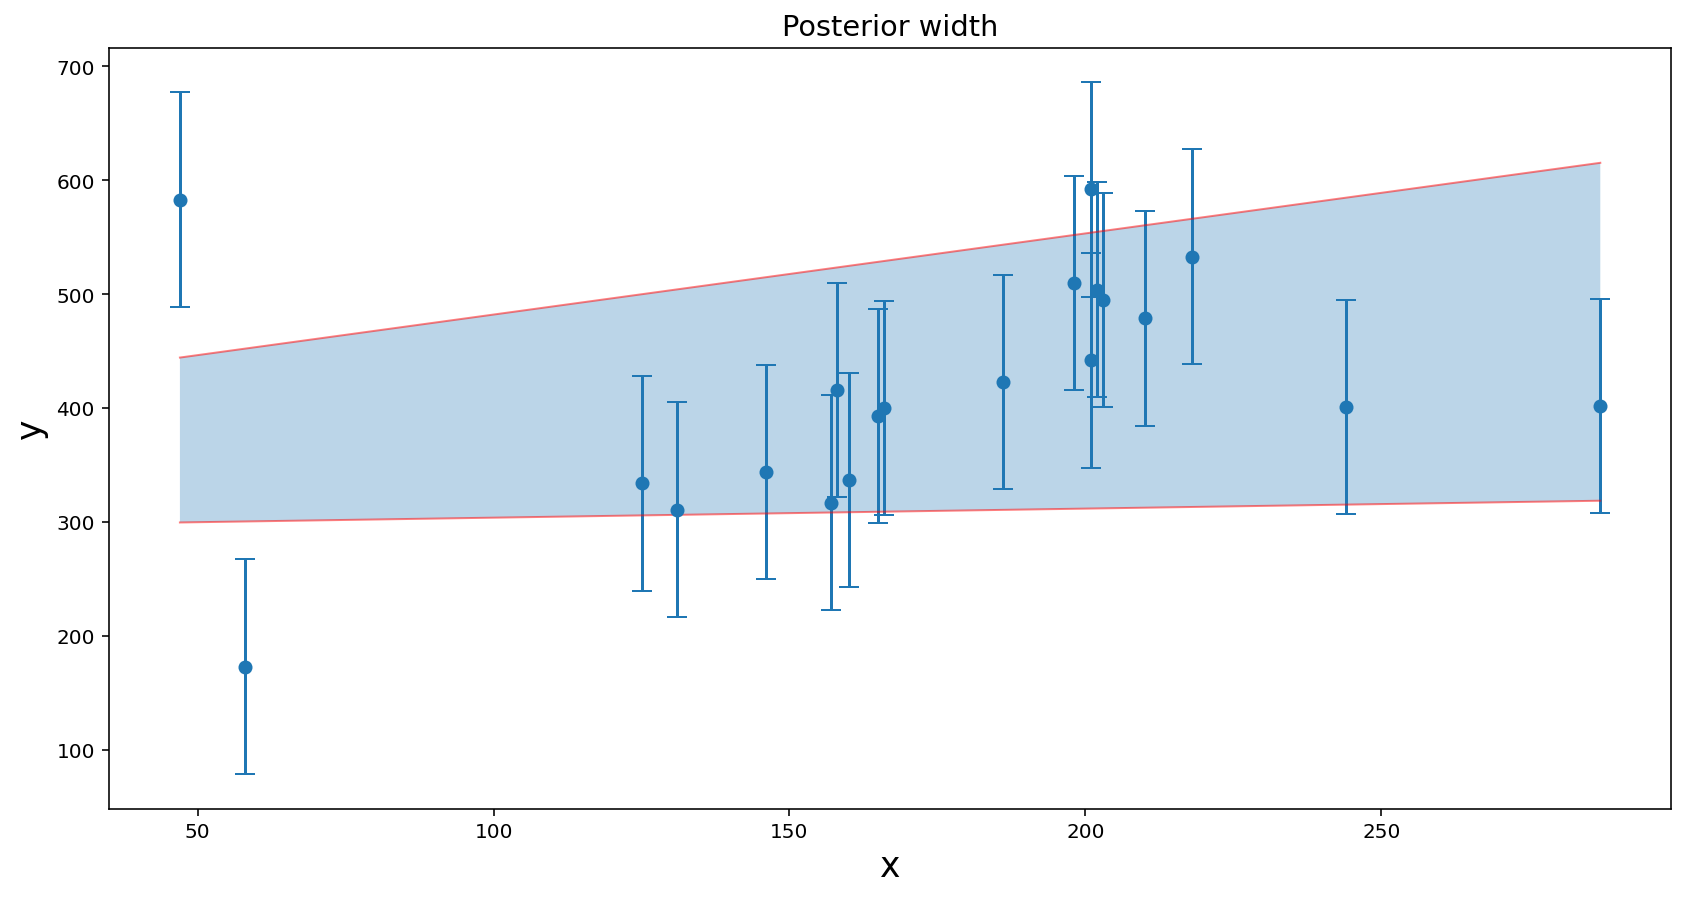

In [16]:
w_mean, w_std = np.mean(w_samples, axis=0), np.std(w_samples, axis=0)

w_span = np.array([w_mean + w_std,
                   w_mean - w_std])
fig = plt.figure(figsize=(14, 7))
lr_plot_posterior_samples(plt.gca(), w_span, hogg_x, hogg_y, sigma_mean, fill=True, title='Posterior width')

## Change point model

Now let's try a more interesting Bayesian analysis. This example is derived from the change-point model in https://docs.pymc.io/notebooks/getting_started.html

---

We will try to get some insight into the number of mining disasters in the United Kingdom that happened between 1851 and 1962. Let's load and plot this data.

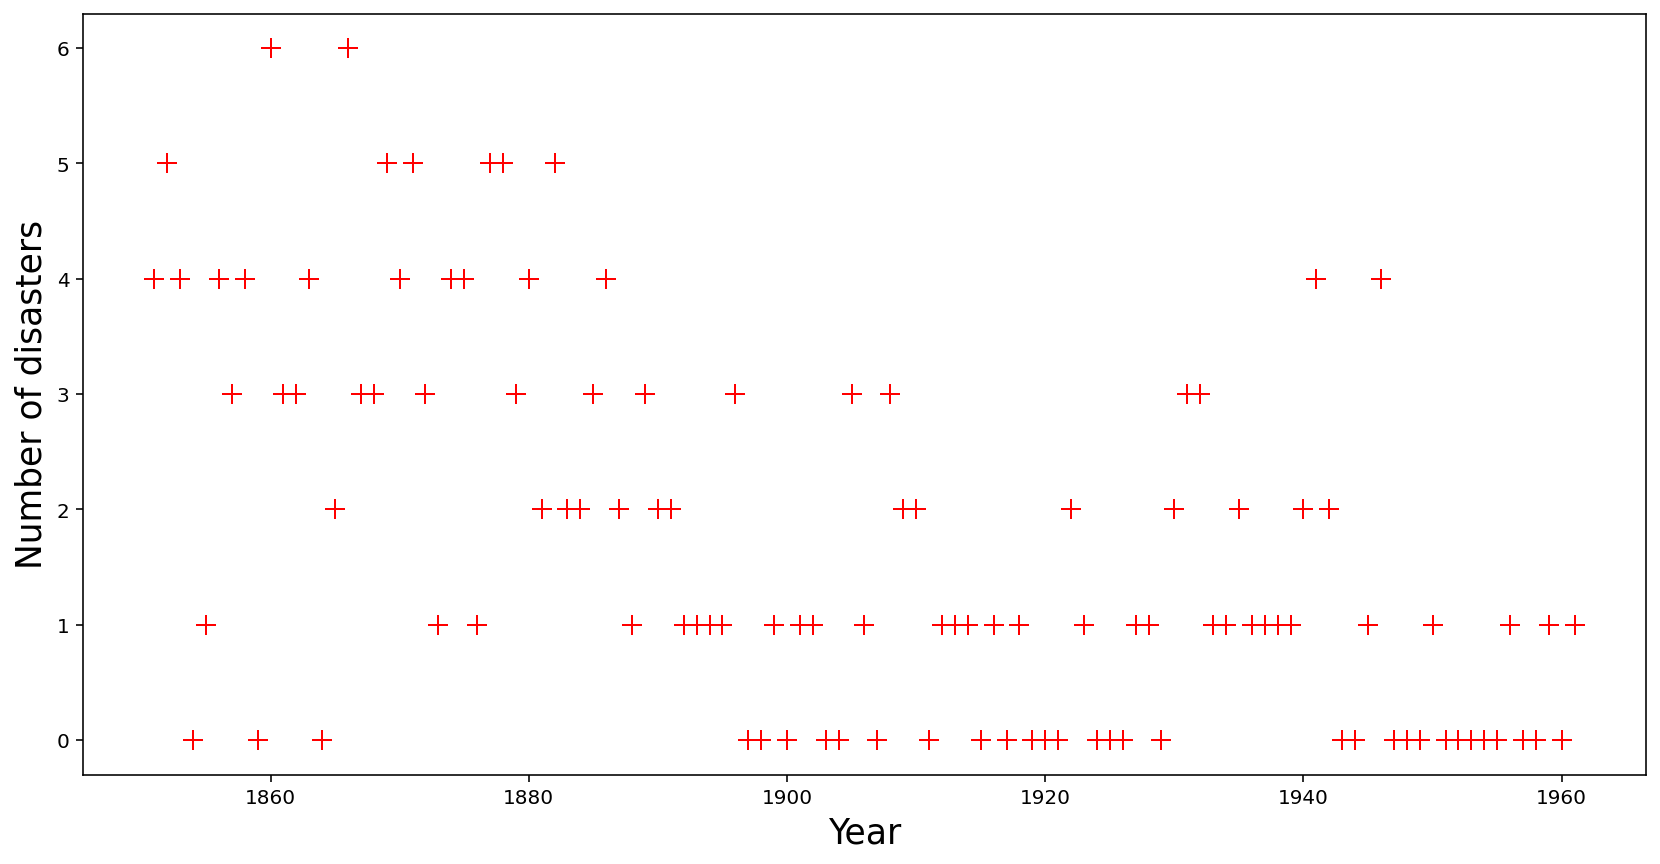

In [17]:
# Coal mining disasters in the UK from 1851 to 1962
disaster_count = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
                            dtype=np.float32)

years = np.arange(1851, 1962, dtype=np.int32)

fig = plt.figure(figsize=(14, 7))
plt.plot(years, disaster_count, 'r+', markersize=10);
plt.xlabel('Year', fontsize='xx-large')
plt.ylabel('Number of disasters', fontsize='xx-large');

Our question is: can we pinpoint any point changes in this time series? Perhaps a year after which the number of disasters decreased or increased? What model could we use to answer such a question?

---

First, lets think about the likelihood - what probability distribution could be seen as generating this data? Each data point is basically a count of events (disasters in a year) - such observations are often well modelled by Poisson distribution.

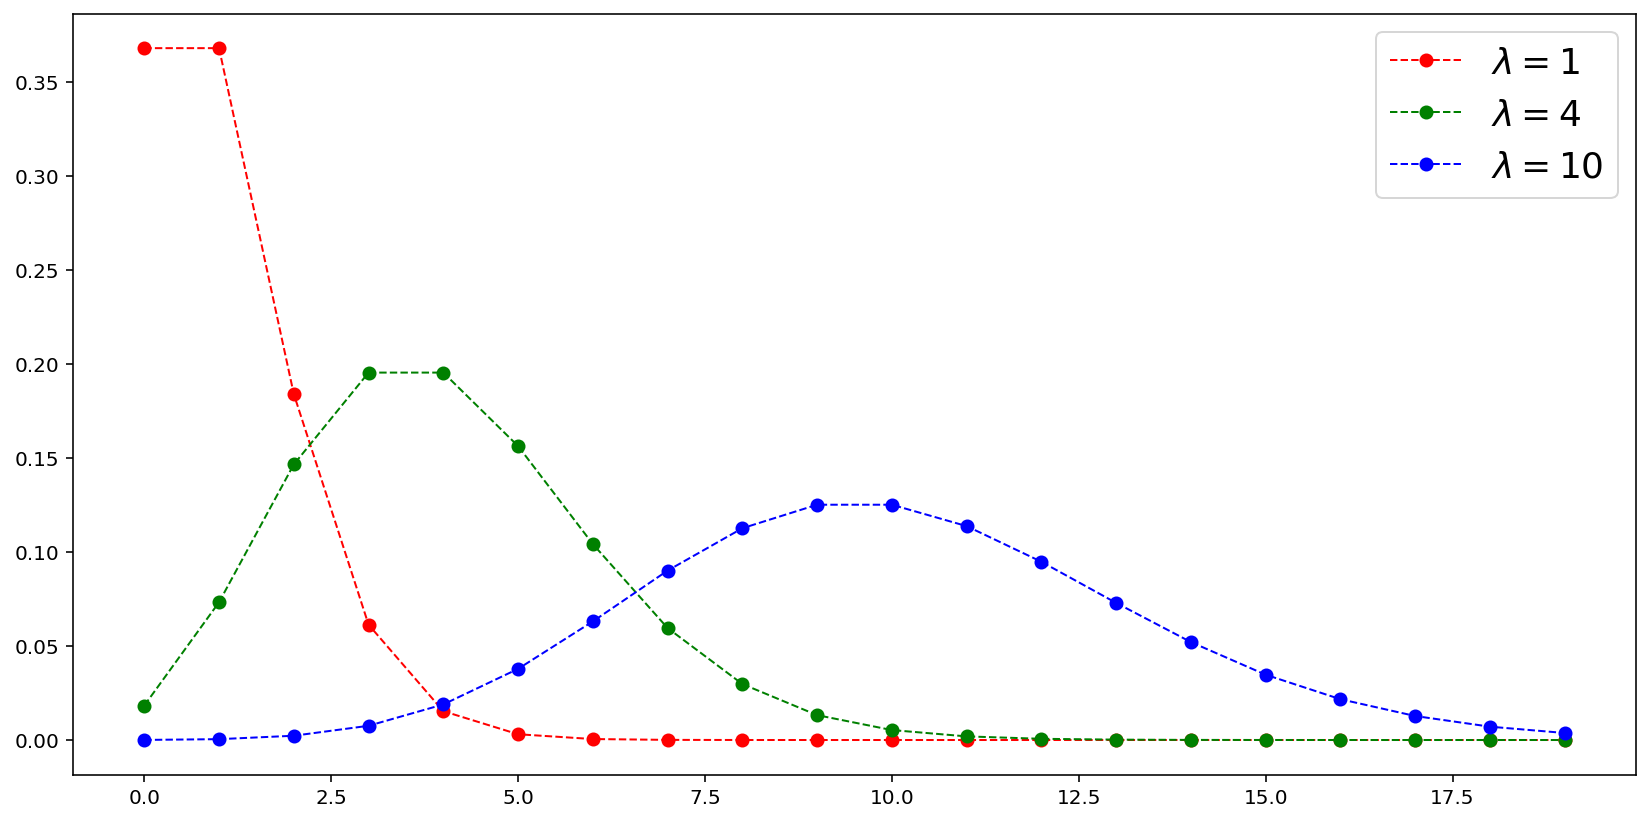

In [18]:
x = np.arange(0, 20, 1.)

p1_prob = tfd.Poisson(rate=1).prob(x)
p4_prob = tfd.Poisson(rate=4).prob(x)
p10_prob = tfd.Poisson(rate=10).prob(x)

fig = plt.figure(figsize=(14, 7))
plt.plot(x, p1_prob, marker='o', ls='--', lw=1.0, color='r', label=r'$\lambda=1$');
plt.plot(x, p4_prob, marker='o', ls='--', lw=1.0, color='g', label=r'$\lambda=4$');
plt.plot(x, p10_prob, marker='o', ls='--', lw=1.0, color='b', label=r'$\lambda=10$')
plt.legend(prop={'size': 18});

So we could write down the likelihood as:

$$\large
\mathrm{count} \sim \textrm{Pos}(\lambda)
$$

where $\lambda$ is the mean rate of disasters.

However, our hypothesis is that there is perhaps a point in this time series where expected disaster count changes. Let it be year $T$. We would then expect one rate of disasters before $T$ - say $\lambda_1$ - and a different rate after $T$ - say $\lambda_2$. Likelihood under such scenario would be:

$$\large
\begin{aligned}
  \mathrm{count} \mid \textrm{year} < T    & \sim \textrm{Pos}(\lambda_1) \\
  \mathrm{count} \mid \textrm{year} \geq T & \sim \textrm{Pos}(\lambda_2)
\end{aligned}
$$

---

Now the priors. We have no idea when the disaster rate changed - if it changed at all. Obviously, uniform prior over all years is a sensible choice:

$$\large
T \sim \mathrm{U}(1851, 1962)
$$

What about the rates? We observe between 0 and 6 disasters annually. So we expect the mean rate to be a small positive number - likely less than 3. An exponential distribution is a good choice for small positive numbers.

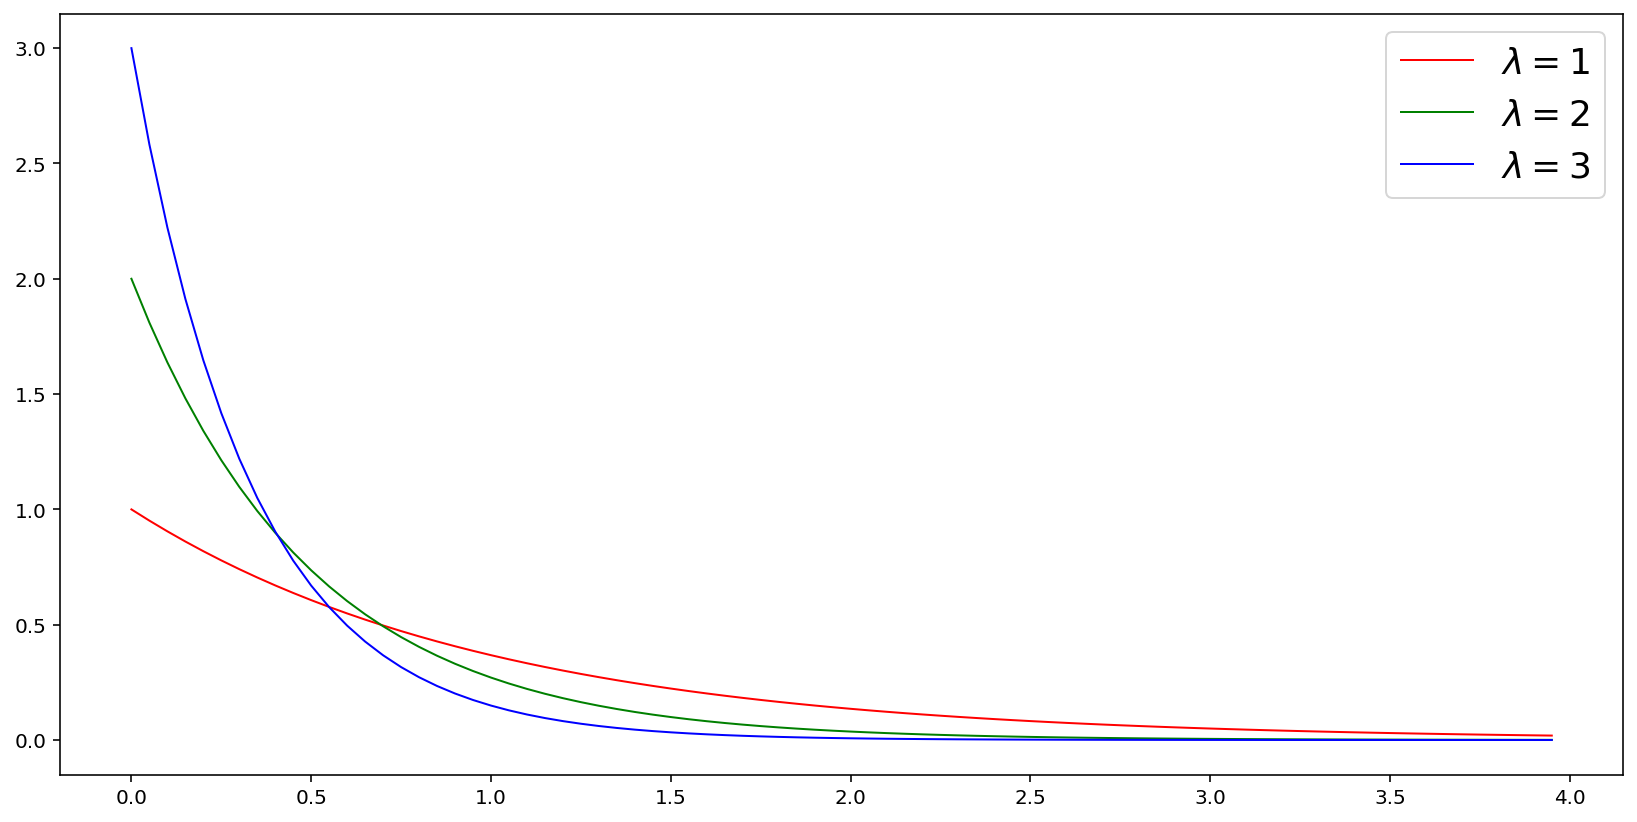

In [19]:
x = np.arange(0, 4, 0.05)

e1_prob = tfd.Exponential(rate=1).prob(x)
e2_prob = tfd.Exponential(rate=2).prob(x)
e3_prob = tfd.Exponential(rate=3).prob(x)

fig = plt.figure(figsize=(14, 7))
plt.plot(x, e1_prob, ls='-', lw=1.0, color='r', label=r'$\lambda=1$');
plt.plot(x, e2_prob, ls='-', lw=1.0, color='g', label=r'$\lambda=2$');
plt.plot(x, e3_prob, ls='-', lw=1.0, color='b', label=r'$\lambda=3$')
plt.legend(prop={'size': 18});

It seems an exponential distribution with rate 1 should be a good prior for mean disaster rate. That means our complete model is:

$$\large
\begin{aligned}
  \lambda_1, \lambda_2 & \sim \mathrm{Exp}(1) \\
  T & \sim \mathrm{U}(1851, 1962) \\
  \mathrm{count} \mid \textrm{year} < T    & \sim \textrm{Pos}(\lambda_1) \\
  \mathrm{count} \mid \textrm{year} \geq T & \sim \textrm{Pos}(\lambda_2)
\end{aligned}
$$

---

Let's implement this model in TensorFlow probability and see if there is any evidence in the data for point change in disaster rate.

In [20]:
# Priors

prior_T        = tfd.Uniform(low=1851, high=1962)
prior_lambda_1 = tfd.Exponential(rate=1.0)
prior_lambda_2 = tfd.Exponential(rate=1.0)

Implement the `point_change_log_joint` function which calculates log-joint density in the Change Point model. You will likely want to use:
- `tf.gather` - this function can pick elements from a list (or a tensor) according to the given indices,
- `tf.range(1851, 1962, dtype=tf.float32)` - a simple way to construct a tensor with list of years,
- `tf.cast(X, tf.int32)` - this will cast tensor `X` to integer values.

In [21]:
def point_change_log_joint(lambda_1, lambda_2, T):
    '''
    Calculate log-joint density in Change Point model.
    
    Args:
        lambda_1: rate before the change
        lambda_2: rate after the change
        T:        change point
               
    Returns:
        Logarithm of the joint density of observations (disaster_count) and
        parameters (lambda_1, lambda_2, T).
    '''

    years = tf.range(1851, 1962, dtype=tf.float32)
    annually_rates = tf.gather((lambda_1, lambda_2), tf.cast(years >= T, tf.int32))

    likelihood = tfd.Poisson(rate=annually_rates)
    log_likelihood = tf.reduce_sum(likelihood.log_prob(disaster_count))

    logp = log_likelihood + prior_T.log_prob(T) + prior_lambda_1.log_prob(lambda_1) + prior_lambda_2.log_prob(lambda_2)
    
    return logp

We will use an uninformative guess for the initial state:
- mean disaster rate is 1 (before and after the supposed change in disaster rate),
- the change in disaster year happened in the middle of the interval for which we have data.

In [22]:
point_change_initial_state = [1.0, 1.0, (1851 + 1962)/2]


point_change_hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=point_change_log_joint,
    step_size=[0.05, 0.05, 1.0],
    num_leapfrog_steps=2)

#point_change_nuts_kernel = tfp.mcmc.NoUTurnSampler(
#    target_log_prob_fn=point_change_log_joint,
#    step_size=[0.05, 0.05, 1.0])


And now we can draw samples.

In [23]:
point_change_samples, point_change_kernel_results = run_chain(point_change_hmc_kernel,
                                                              point_change_initial_state,
                                                              num_results=2000,
                                                              num_burnin_steps=1000)

print("Acceptance rate: ", point_change_kernel_results.is_accepted.numpy().mean())

Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).
Acceptance rate:  0.626


Let's plot the results. We will plot posterior disribution (histogram) for each parameter in our model.

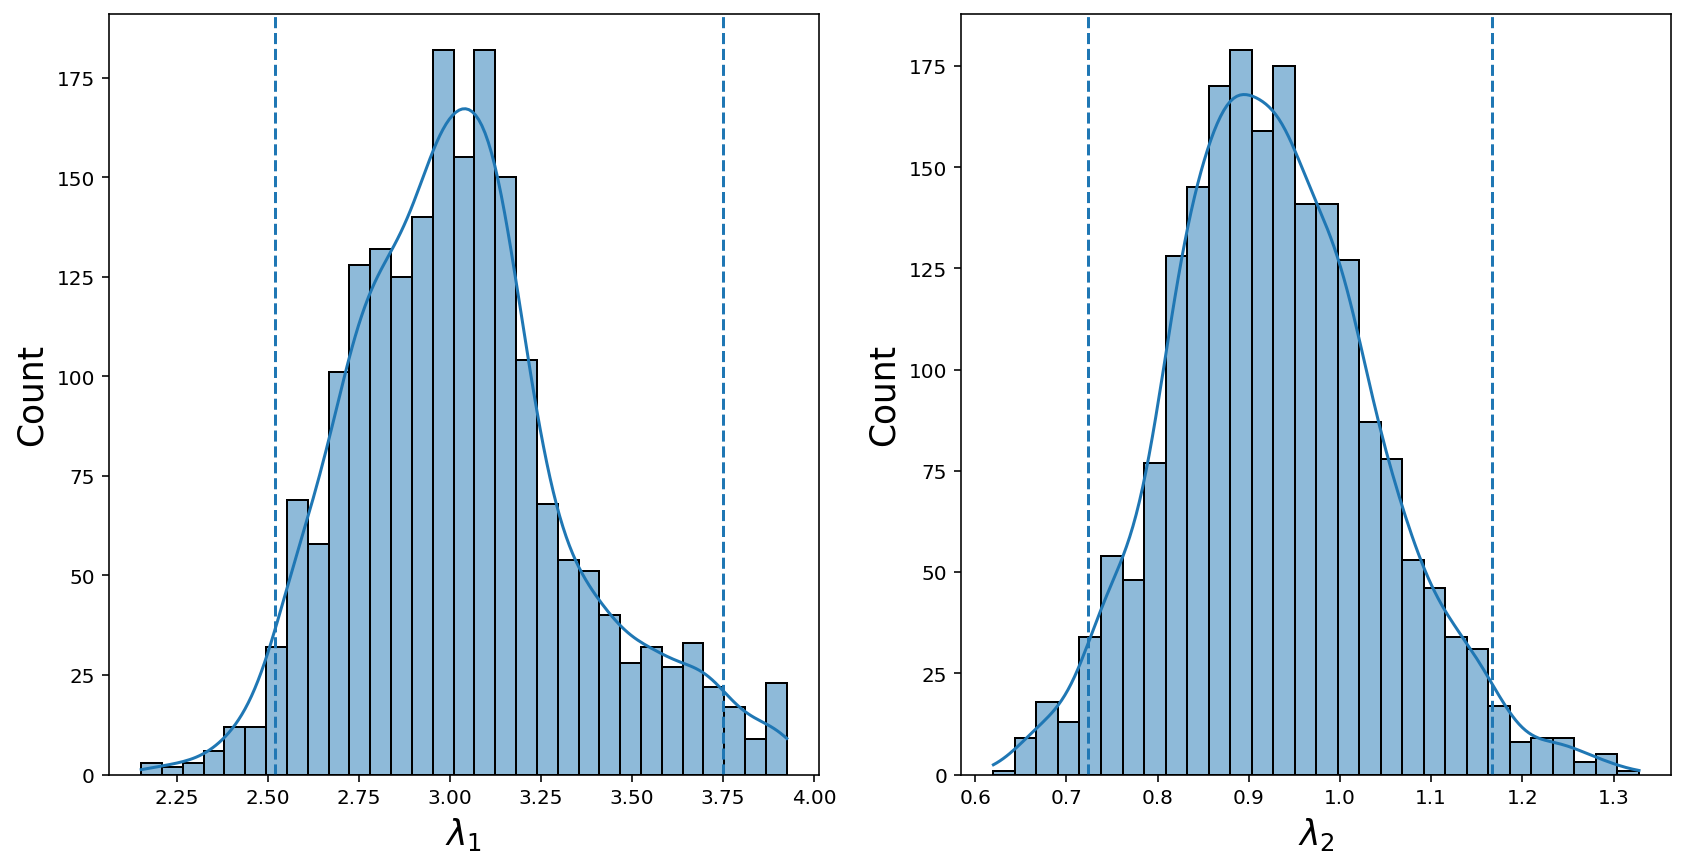

In [24]:
plot_posterior_dist(point_change_samples[:2], [r'$\lambda_1$', r'$\lambda_2$'])

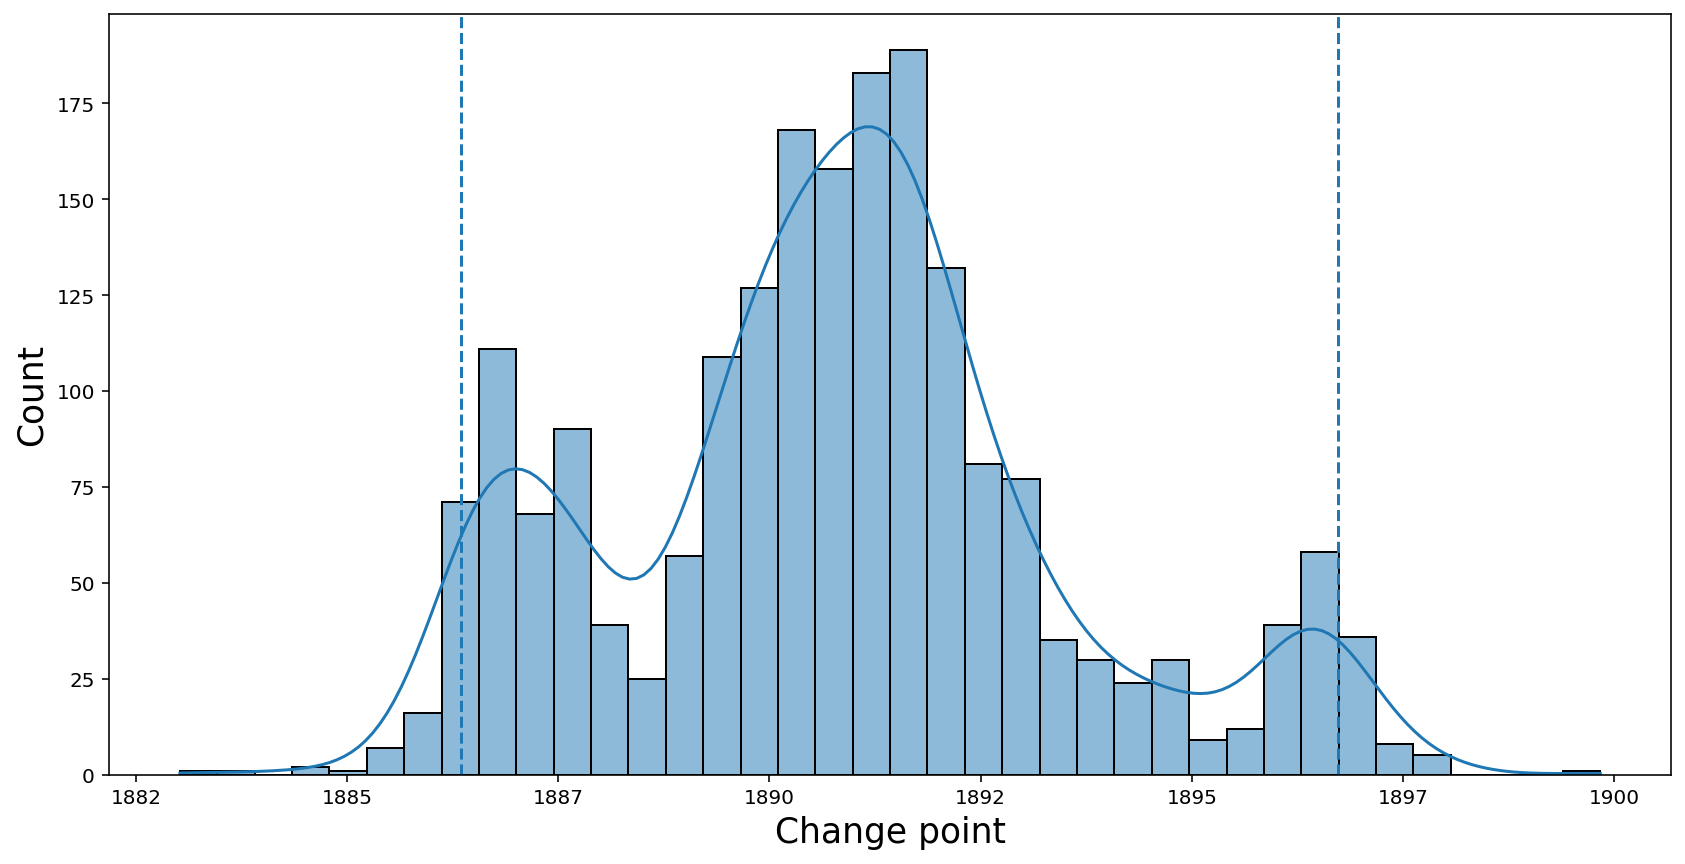

In [25]:
plot_posterior_dist([point_change_samples[2]], ['Change point'], round_ticks=True)

# Interval Change Model

The problem with the model described above is that it assumes a point-wise change. Changes in mining safety may as well take several years.

Your task now is to extend the Change Point model to a model of an interval change. In other words, we expect a model that assumes a change like this:



Your model should have following parameters:

- $\lambda_1$, $\lambda_2$ - expected disaster rates (respectively, before and after the change),
- $T$ - center of the change interval,
- $L$ - width of the change interval.

---

**Write down your model here (preferably with formal notation). Also, include a short justification for your model**

Next, define a prior for $L$. Other parameter can use priors from the previous model. Finally, implement the `interval_change_log_joint` function, which should calculate log-joint density in your model.

In [26]:
raise Exception('Define a prior distribution for the width of the change interval.')

#prior_L = ???

def interval_change_log_joint(lambda_1, lambda_2, T, L):
    '''
    Calculate log-joint density in Change Interval model.
    
    Args:
        lambda_1: rate before the change
        lambda_1: rate after the change
        T:        center of the change interval
        L:        width of the change interval
        
    Returns:
        Logarithm of the joint density of observations (disaster_count) and
        parameters (lambda_1, lambda_2, T, L).
    '''
    
    raise Exception('Unimplemented.')
    
    #logp = ??
    
    return logp

Exception: Define a prior distribution for the width of the change interval.

Let's infer parameter of your model and see how it performs. Again, we start from an uninformative guess for the initial state.

In [ ]:
interval_change_initial_state = [1.0, 1.0, (1851 + 1962)/2, 5.0]


interval_change_hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=interval_change_log_joint,
    step_size=[0.05, 0.05, 1.0, 1.0],
    num_leapfrog_steps=2)

#interval_change_nuts_kernel = tfp.mcmc.NoUTurnSampler(
#    target_log_prob_fn=interval_change_log_joint,
#    step_size=[0.05, 0.05, 1.0, 1.0])

In [ ]:
interval_change_samples, interval_change_kernel_results = run_chain(interval_change_hmc_kernel,
                                                                    interval_change_initial_state,
                                                                    num_results=1000,
                                                                    num_burnin_steps=1000)

print("Acceptance rate: ", interval_change_kernel_results.is_accepted.numpy().mean())

Let's plot the posterior distributions.

In [ ]:
plot_posterior_dist(interval_change_samples[:2], [r'$\lambda_1$', r'$\lambda_2$'])

In [ ]:
plot_posterior_dist(interval_change_samples[2:],
                    ['Change interval center', 'Change interval width'],
                    round_ticks=True)